In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Instantiate a quantum register holding two qubits
# and a classical register holding two classical bits
q_reg = QuantumRegister(size=2, name="q")

In [127]:
# Instantiate a circuit containing the bits and qubits
circuit = QuantumCircuit(q_reg)


# Set the first qubit in a superposition of ∣0⟩ and ∣1⟩
# For this, use the Hadamard gate
circuit.h(q_reg[0])

# Then use the control-not gate, with the first qubit as the control
# and the sencond qubit as the target. This should entangle the qubits
# in a state ( ∣00⟩ + ∣11⟩ ) / sqrt(2)
circuit.cx(control_qubit=q_reg[0], target_qubit=q_reg[1])

# Visualize the circuit
circuit.draw()


┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [128]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler import generate_preset_pass_manager
from dotenv import load_dotenv
import os


# To run and measure the circuit, instantiate a service that runs the circuit
# In order to instantiate a service, create an account at https://quantum.ibm.com/
# and use your IBM token (find it at /account)
load_dotenv()
token = os.getenv("IBM_TOKEN")
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

# First, simmulate running the circuit, to make sure everything is ok.
# Use a backend specifically for simulating (there's a lot of them)
backend = FakeManilaV2()

# Use the transpiler to optimize the circuit for the backend, creating the circuit
# that obeys the Instruction Set Architectrue (ISA)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

In [129]:
# Visualize the original and ISA cirucit to see the difference
print(f"ORIGINAL CIRCUIT: \n{circuit}\n")
print(f"ISA CIRCUIT:\n{isa_circuit.draw(idle_wires=False)}") # don't present wires that aren't used

ORIGINAL CIRCUIT: 
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

ISA CIRCUIT:
global phase: π/4
         ┌─────────┐┌────┐┌─────────┐     
q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──■──
         └─────────┘└────┘└─────────┘┌─┴─┐
q_1 -> 1 ────────────────────────────┤ X ├
                                     └───┘


In [130]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.quantum_info import SparsePauliOp

# Observables are letter codes representing tensor produts of Pauli Operators on qubits
# In this case, there are two cubits, so each obserable is a 2-letter-code
# e.g. "ZZ" means (Pauli Operator Z on qubit 1 @ Pauli Operator Z on qubit 2)
observables_labels = ["ZZ", "XX", "YY", "XI", "ZI", "YI", "IX", "IY", "IZ"]
observables = [SparsePauliOp(label) for label in observables_labels]



In [131]:
no_of_iterations = 10000
estimator = Estimator(mode=backend, options={"default_shots":no_of_iterations})
mapped_observables = [observable.apply_layout(isa_circuit.layout) for observable in observables]
job = estimator.run([(isa_circuit, mapped_observables)])

print(job.status())
print(job.result())


JobStatus.RUNNING
PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(9,), dtype=float64>), stds=np.ndarray(<shape=(9,), dtype=float64>), shape=(9,)), metadata={'target_precision': 0.01, 'shots': 10000, 'circuit_metadata': {}})], metadata={'version': 2})


In [132]:
# Before plotting the results, we can set up our expectations
from qiskit.quantum_info import Statevector
from sympy import nsimplify


sv = Statevector(circuit)
expectation_values_simple = [
    nsimplify(sv.expectation_value(operator))
    for operator in observables
    ]

print(list(zip(observables_labels, expectation_values_simple)))

[('ZZ', 1), ('XX', 1), ('YY', -1), ('XI', 0), ('ZI', 0), ('YI', 0), ('IX', 0), ('IY', 0), ('IZ', 0)]


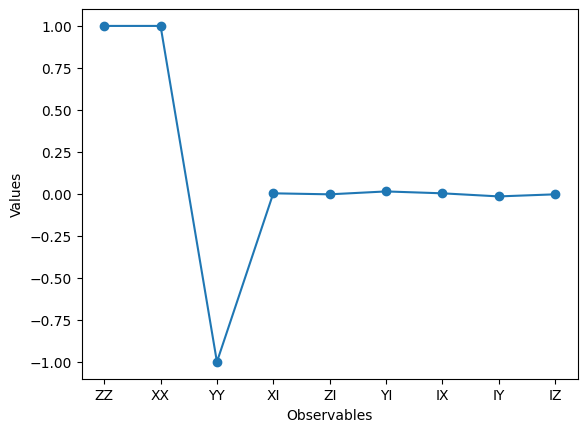

In [133]:
import matplotlib.pyplot as plt

values = job.result()[0].data.evs

plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

In [134]:
# The graph shows average values of each observable over all iterations
# Compare the expected values to the results, by subtracting the avg results from the expected ones
import numpy as np

expectation_values_simple = np.array(expectation_values_simple, dtype=float)
diff_percentage = np.abs(expectation_values_simple - values) * 100
diff_percentage_simple = np.round(diff_percentage, 2).tolist()

print("The percentage of difference between the expected and SIMULATED calculated result of observables:")
print(list(zip(observables_labels, diff_percentage_simple)))


The percentage of difference between the expected and SIMULATED calculated result of observables:
[('ZZ', 0.0), ('XX', 0.0), ('YY', 0.0), ('XI', 0.36), ('ZI', 0.24), ('YI', 1.48), ('IX', 0.36), ('IY', 1.48), ('IZ', 0.24)]


In [124]:
# Finally run this on a real quantum computer

backend_real = service.least_busy(
    simulator=False, operational=True
)
estimator = Estimator(mode=backend_real)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend_real)

isa_circuit = pm.run(circuit)
mapped_observables = [observable.apply_layout(isa_circuit.layout) for observable in observables]
job = estimator.run([(isa_circuit, mapped_observables)])

print(job.status())
print(job.result())

QUEUED
PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(9,), dtype=float64>), stds=np.ndarray(<shape=(9,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(9,), dtype=float64>), shape=(9,)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})


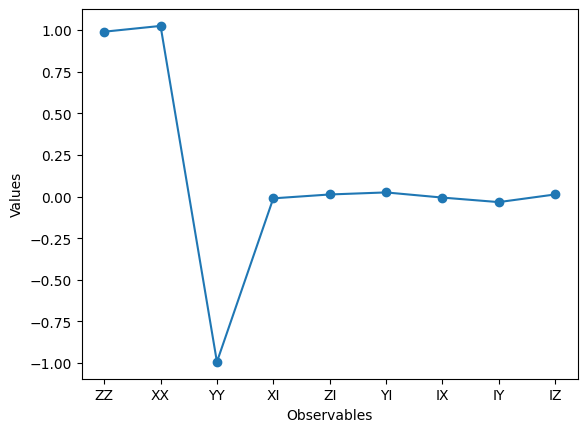

The percentage of difference between the expected and calculated result of observables:
[('ZZ', 1.02), ('XX', 2.45), ('YY', 0.69), ('XI', 1.08), ('ZI', 1.24), ('YI', 2.47), ('IX', 0.63), ('IY', 3.34), ('IZ', 1.25)]


In [ ]:
values = job.result()[0].data.evs

plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

diff_percentage = np.abs(expectation_values_simple - values) * 100
diff_percentage_simple = np.round(diff_percentage, 2).tolist()

print("The percentage of difference between the expected and REAL calculated result of observables:")
print(list(zip(observables_labels, diff_percentage_simple)))